# Looking at smog

## import and initialize dataframes

In [1]:
from Startup import *

finished standard imports
dict_items([('spark.app.name', 'Weather_PCA'), ('spark.executor.memory', '3g'), ('spark.executor.cores', '1'), ('spark.cores.max', '4'), ('spark.default.parallelism', '10'), ('spark.logConf', 'True')])
started SparkContext and SQLContext in 6.21 seconds
loaded weather.parquet in 6.95 seconds
loaded stations.parquet in 0.23 seconds
registered dataframes as tables in 0.36 seconds


## Get Measurement count of haze/smog by year

In [3]:
%%time
# qry = """SELECT Year, COUNT(Measurement) AS count
# FROM parquet.`/tmp/weather.parquet` 
# WHERE Measurement='WT08' 
# GROUP BY Year 
# ORDER BY Year DESC"""

qry = """SELECT Year, COUNT(Measurement) AS count
FROM parquet.`/mnt/d/02_acads/3.SP-20/dsc291/Public-DSC291/Data/weather.parquet` 
WHERE Measurement='WT08' 
GROUP BY Year 
ORDER BY Year DESC"""


print(qry)
smogCount = sqlContext.sql(qry)

SELECT Year, COUNT(Measurement) AS count
FROM parquet.`/mnt/d/02_acads/3.SP-20/dsc291/Public-DSC291/Data/weather.parquet` 
WHERE Measurement='WT08' 
GROUP BY Year 
ORDER BY Year DESC
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 373 ms


In [4]:
%%time
smogCount.show(10)

+----+-----+
|Year|count|
+----+-----+
|2012|  444|
|2011|  910|
|2010|  915|
|2009|  905|
|2008|  901|
|2007|  904|
|2006|  878|
|2005|  573|
|2004|  463|
|2003|  455|
+----+-----+
only showing top 10 rows

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 16.5 s


### Now plot this

In [5]:
smogyears = smogCount.select('Year').collect()
smogcounts = smogCount.select('count').collect()

Text(0.5, 0, 'year')

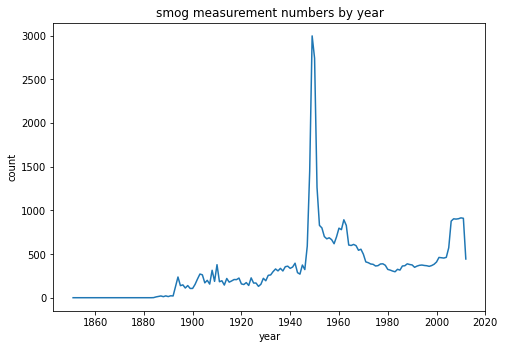

In [6]:
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
fig1 = plt.figure()
ax1 = fig1.add_axes([0,0,1,1])
ax1.plot(smogyears,smogcounts)
ax1.set_title('smog measurement numbers by year')
ax1.set_ylabel('count')
ax1.set_xlabel('year')

## now, get all the data

In [8]:
%%time
query="""
SELECT *
FROM weather
WHERE measurement='WT08' and year>1960 and SUBSTRING(Station, 1, 2) = 'US'
"""
print(query)
WT08_df=sqlContext.sql(query)
WT08_pdf=WT08_df.toPandas()


SELECT *
FROM weather
WHERE measurement='WT08' and year>1960 and SUBSTRING(Station, 1, 2) = 'US'

CPU times: user 188 ms, sys: 156 ms, total: 344 ms
Wall time: 21.5 s


In [9]:
WT08_df.count()

24551

In [10]:
WT08_pdf.head(5)

,Station,Measurement,Year,Values
0,USW00093819,WT08,1961,"[0, 60, 0, 60, 0, 126, 0, 60, 0, 126, 0, 126, ..."
1,USW00093819,WT08,1962,"[0, 60, 0, 126, 0, 126, 0, 126, 0, 126, 0, 60,..."
2,USW00093819,WT08,1963,"[0, 126, 0, 126, 0, 60, 0, 60, 0, 60, 0, 126, ..."
3,USW00093819,WT08,1964,"[0, 126, 0, 126, 0, 126, 0, 126, 0, 126, 0, 60..."
4,USW00093819,WT08,1965,"[0, 126, 0, 126, 0, 60, 0, 60, 0, 60, 0, 60, 0..."


In [11]:
wt08_graphs=[]
for i in range(WT08_pdf.shape[0]):
    graph=unpackArray(WT08_pdf.iloc[i,3],np.float16)
    graph=np.nan_to_num(graph)
    wt08_graphs.append(graph)
wt08_graphs=np.stack(wt08_graphs)

In [12]:
print(wt08_graphs.shape)
print(wt08_graphs[0:5,0:10])

(24551, 365)
[[1. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 0. 0.]
 [0. 0. 1. 1. 1. 1. 1. 0. 0. 0.]]


In [13]:
from scipy.stats import sem

In [14]:
wt08mean = np.mean(wt08_graphs, axis=0)
wt08std = np.std(wt08_graphs, axis=0)
wt08stderr = sem(wt08_graphs, axis=0)

/home/ubuntu/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [15]:
N = 30
smoothed=np.convolve(np.hstack((wt08mean,wt08mean,wt08mean)), np.ones((N,))/N, mode='same') 
meansmooth = smoothed[365:2*365]

Text(0.5, 0, 'day')

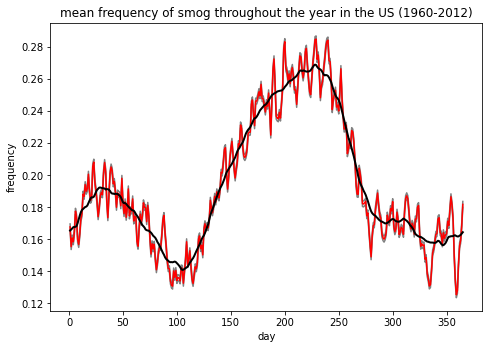

In [16]:
fig2 = plt.figure()
ax2 = fig2.add_axes([0,0,1,1])
ax2.plot(np.arange(1,366),wt08mean+wt08stderr,color='gray')
ax2.plot(np.arange(1,366),wt08mean-wt08stderr,color='gray')
ax2.plot(np.arange(1,366),wt08mean,color='red')
ax2.plot(np.arange(1,366),meansmooth,color='black',lw=2)
ax2.set_title('mean frequency of smog throughout the year in the US (1960-2012)')
ax2.set_ylabel('frequency')
ax2.set_xlabel('day')

## Now let's look at smoggy days within +- 10 days 

In [17]:
%%time
dayRange = 10

wt08_range=[]
N = 2*dayRange+1
for i in range(wt08_graphs.shape[0]):
    yearData = wt08_graphs[i,:]
    freq_range=np.convolve(np.hstack((yearData,yearData,yearData)), np.ones((N,))/N, mode='same')
    freq_range = freq_range[365:2*365]
    wt08_range.append(freq_range)
wt08_range=np.stack(wt08_range)
print(wt08_range.shape)

(24551, 365)
CPU times: user 1.62 s, sys: 453 ms, total: 2.08 s
Wall time: 2.2 s


In [18]:
print(wt08_range[1:30,1:1:5])

[]


In [19]:
wt08_range_mean = np.mean(wt08_range, axis=0)
wt08_range_std = np.std(wt08_range, axis=0)
wt08_range_stderr = sem(wt08_range, axis=0)

Text(0.5, 0, 'day')

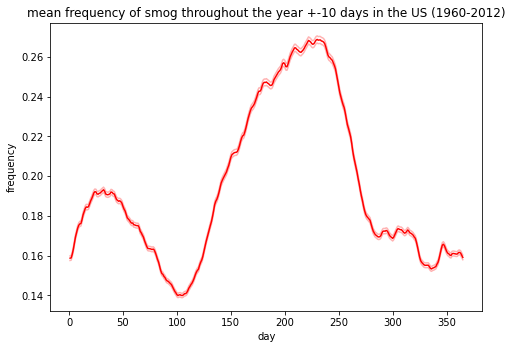

In [20]:
fig2 = plt.figure()
ax2 = fig2.add_axes([0,0,1,1])
ax2.plot(np.arange(1,366),wt08_range_mean+wt08_range_stderr,color=[1,0.7,0.7])
ax2.plot(np.arange(1,366),wt08_range_mean-wt08_range_stderr,color=[1,0.7,0.7])
ax2.plot(np.arange(1,366),wt08_range_mean,color='red')
ax2.set_title('mean frequency of smog throughout the year +-10 days in the US (1960-2012)')
ax2.set_ylabel('frequency')
ax2.set_xlabel('day')

## okay, now break it up by year

In [21]:
dayRange = 10

In [22]:
%%time
wt08_byyear=[]
N = 2*dayRange+1
years = np.unique(WT08_pdf['Year'])
for year in years:
    wt08_thisyear = []
    for i in range(wt08_graphs.shape[0]):
        if WT08_pdf['Year'][i] == year:
            yearData = wt08_graphs[i,:]
            freq_range=np.convolve(np.hstack((yearData,yearData,yearData)), np.ones((N,))/N, mode='same')
            freq_range = freq_range[365:2*365]
            wt08_thisyear.append(freq_range)
    wt08_byyear.append(np.mean(wt08_thisyear, axis=0))
wt08_byyear=np.stack(wt08_byyear)
print(wt08_byyear.shape)

(52, 365)
CPU times: user 29.1 s, sys: 62.5 ms, total: 29.2 s
Wall time: 31.1 s


In [23]:
wt08_byyear_mean = np.mean(wt08_byyear, axis=0)
wt08_byyear_std = np.std(wt08_byyear, axis=0)
wt08_byyear_stderr = sem(wt08_byyear, axis=0)

In [24]:
from matplotlib import cm
colmap = cm.get_cmap('jet', len(years))
colors = colmap(range(len(years)))
# colors = cm.jet(np.arange(len(years)))
# colors

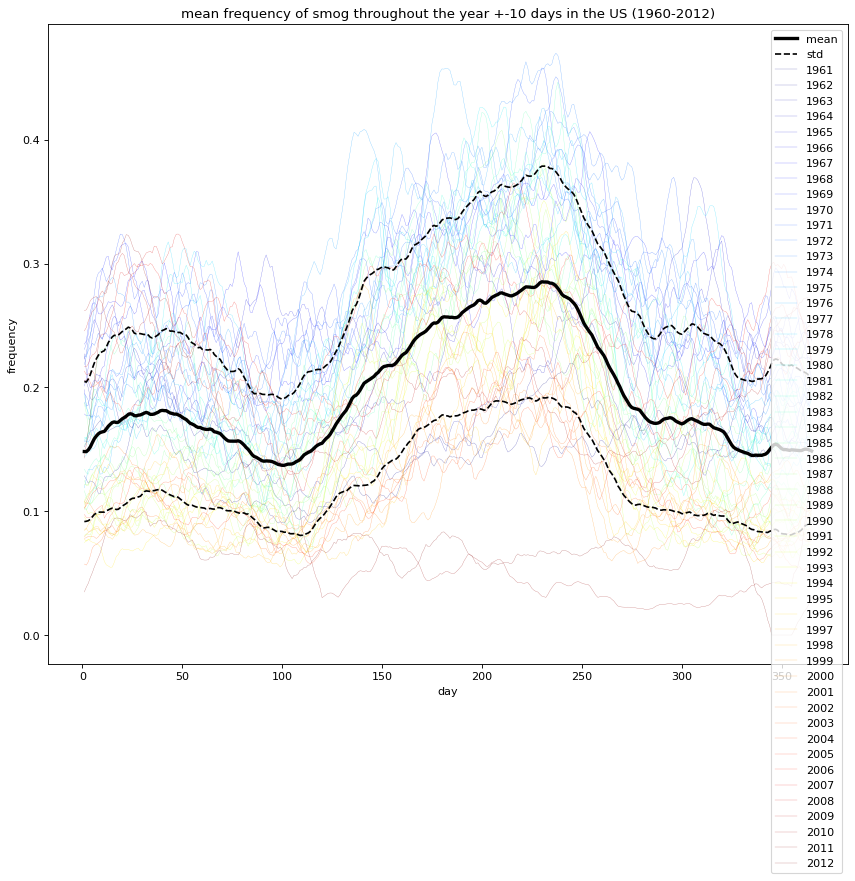

In [25]:
fig2 = plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')
ax2 = fig2.add_axes([0,0,1,1])
theLines = []
for i in range(len(years)):
    yrplot, = ax2.plot(np.arange(1,366),wt08_byyear[i,:],color=colors[i,:3],alpha=0.5,lw=0.3,label=str(years[i]))
    theLines.append(yrplot)
stdplot, = ax2.plot(np.arange(1,366),wt08_byyear_mean+wt08_byyear_std,color='black',linestyle='--',label='std')
ax2.plot(np.arange(1,366),wt08_byyear_mean-wt08_byyear_std,color='black',linestyle='--')
meanplot, = ax2.plot(np.arange(1,366),wt08_byyear_mean,color='black',lw=3,label='mean')
ax2.set_title('mean frequency of smog throughout the year +-10 days in the US (1960-2012)')
ax2.set_ylabel('frequency')
ax2.set_xlabel('day')
allLines = [meanplot, stdplot]
for i in range(len(years)):
    allLines.append(theLines[i])
ax2.legend(handles=allLines)